In [2]:
import numpy as np
from itertools import combinations
from matplotlib import cm
from __future__ import division
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import sparse 
import seaborn as sns
sns.set(rc={'axes.facecolor':'#F5F5F5'})
%matplotlib inline

from sklearn.model_selection import StratifiedShuffleSplit,StratifiedKFold
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn import neighbors
from sklearn.model_selection import KFold

from time import time

# Importing data

In [3]:
# Function to load csr matrix of samples and list of colnames from file
def load_csr_from_csv(filename):
    indices = np.loadtxt(filename+"_indices.csv",unpack=True,delimiter=",")
    indptr = np.loadtxt(filename+"_indptr.csv",unpack=True,delimiter=",")
    shape = np.loadtxt(filename+"_shape.csv",unpack=True,delimiter=",")
    col_names = np.loadtxt(filename+"_col_names.csv",unpack=True,delimiter=",",dtype=str)
    data = np.ones_like(indices,dtype=np.int8)
    
    return sparse.csr_matrix((data, indices, indptr),
                         shape = shape),col_names

In [4]:
# returns the csr matrix of samples and list of colnames
def load_csr_from_csv_with_data(filename):
    data = np.loadtxt(filename+"_data.csv",unpack=True,delimiter=",",dtype=np.int8)
    indices = np.loadtxt(filename+"_indices.csv",unpack=True,delimiter=",")
    indptr = np.loadtxt(filename+"_indptr.csv",unpack=True,delimiter=",")
    shape = np.loadtxt(filename+"_shape.csv",unpack=True,delimiter=",")
    col_names = np.loadtxt(filename+"_col_names.csv",unpack=True,delimiter=",",dtype=str)
    
    return sparse.csr_matrix((data, indices, indptr),
                         shape = shape),col_names

In [27]:
# Load the full mutation list dataset with column names from file
X, col_names = load_csr_from_csv("sparse_csr")
y,std = np.loadtxt("target_values.csv",unpack=True,delimiter=",")
print X.shape

(54025, 1879)


In [7]:
# Retrieve all the mutants with single mutations 
# and create the look up table for this single mutations
single_mutations = {}
single_mut_idx = []

for i in xrange(X.shape[0]):
    if X.getrow(i).indices.shape[0] == 1: #how many mutations in this mutant? one?
        index = X.getrow(i).indices[0]
        mutation = col_names[index]
#         print mutation, i
        if mutation not in single_mutations:
            single_mutations[mutation] = {"id":index,"mutants":[i]}
            single_mut_idx.append(i)
        else:
            single_mutations[mutation]["mutants"].append(i)
            
            

In [8]:
print "Total number of single mutation mutants: %d" % len(single_mut_idx)

Total number of single mutation mutants: 1114


# SVR

In [11]:
skf = StratifiedKFold(n_splits=5,shuffle=True)
train_idx, test_idx = skf.split(X,y_bin).next()
test_idx.shape
x,y = X[test_idx,:],y_bin[test_idx]
x.shape
test_idx

array([    5,     6,    13, ..., 54016, 54021, 54024])

### Grid search

#### Choosing kernel

In [132]:
## train the classifer using full data set
print "Training SVM..."
t1 = time()
clf = SVC(C=100, gamma=0.1, class_weight={0:class_weights[0],1:class_weights[1]})
parameters = {"kernel":('linear', 'poly', 'rbf', 'sigmoid')}
clf = GridSearchCV(clf, param_grid=parameters, cv = 5, n_jobs = -1,\
                   fit_params = {'sample_weight':sample_weights})
clf.fit(X, y_bin)
print "Time taken: %.f"%(time()-t1)

Training SVM...
Time taken: 730


In [133]:
print str(clf.best_params_)

{'kernel': 'rbf'}


#### Choosing C and gamma

In [135]:
print "Running SVM parameter grid search..."
skf = StratifiedKFold(n_splits = 6, shuffle = True) 

for train_index, test_index in skf.split(X, y_bin):
    t1 = time()
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_bin[train_index], y_bin[test_index]
    
    clf = SVC(class_weight={0:class_weights[0],1:class_weights[1]})

    parameters = {"C":(0.1,10,100,1000),"gamma":(0.01,0.1,1,10)}
    clf = GridSearchCV(clf,param_grid=parameters,cv = 5,n_jobs=-1,\
                       fit_params={'sample_weight':sample_weights[train_index]})
    clf.fit(X_train, y_train)
    yhat = clf.predict(X_test)
    print "Test set Accuracy: %.2f" % metrics.accuracy_score(y_test, yhat, sample_weight = sample_weights[test_index])
    print str(clf.best_params_)
    print "Time taken: %.f s"%(time()-t1)

### Training classifier

In [13]:
## train the classifer using full data set
print "Training SVM..."
t1 = time()
clf = SVR(C=100, gamma=0.1)
clf.fit(X, y)
print "Time taken: %.f"%(time()-t1)

Training SVM...


SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [15]:
yhat = clf.predict(X)

In [21]:
yhat

array([ 3.85319011,  1.40114079,  1.40109805, ...,  1.20087406,
        1.40159136,  1.40233384])

In [28]:
y

array([ 3.71921,  1.30103,  1.30103, ...,  1.30103,  1.30152,  1.30213])

In [19]:
clf.score(X, yhat)

1.0

# Assessing quality

In [20]:
r = 200
x = np.arange(r)
weight_order = sample_weights.argsort()[::-1]

TP = (yhat == y_bin) & (y_bin == 1)
TP = TP[weight_order][:r]

TN = (yhat == y_bin) & (y_bin == 0)
TN = TN[weight_order][:r]

FP = (yhat != y_bin) & (yhat == 1)
FP = FP[weight_order][:r]

FN = (yhat != y_bin) & (yhat == 0)
FN = FN[weight_order][:r]

F = (yhat != y_bin)
F = F[weight_order][:r]

T = (yhat == y_bin)
T = T[weight_order][:r]

plt.figure(figsize = [15,10])
plt.plot(x[TP],sample_weights[weight_order][:r][TP].cumsum(),'.')
plt.plot(x[TN],sample_weights[weight_order][:r][TN].cumsum(),'.')
plt.plot(x[FP],sample_weights[weight_order][:r][FP].cumsum(),'.')
plt.plot(x[FN],sample_weights[weight_order][:r][FN].cumsum(),'.')
plt.legend(('TP','TN',"FP","FN"), loc = 2);

NameError: name 'sample_weights' is not defined

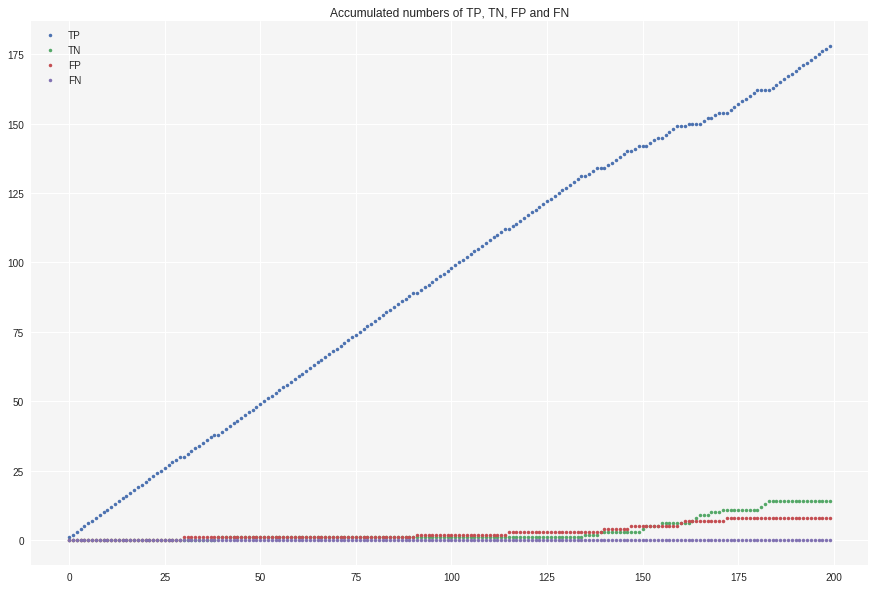

In [24]:
plt.figure(figsize = [15,10])
plt.plot(x,TP.cumsum(), '.')
plt.plot(x,TN.cumsum(), '.')
plt.plot(x,FP.cumsum(), '.')
plt.plot(x,FN.cumsum(), '.')
plt.legend(('TP','TN',"FP","FN"),loc=2)
plt.title('Accumulated numbers of TP, TN, FP and FN');

False predictions start at #30 sample weight


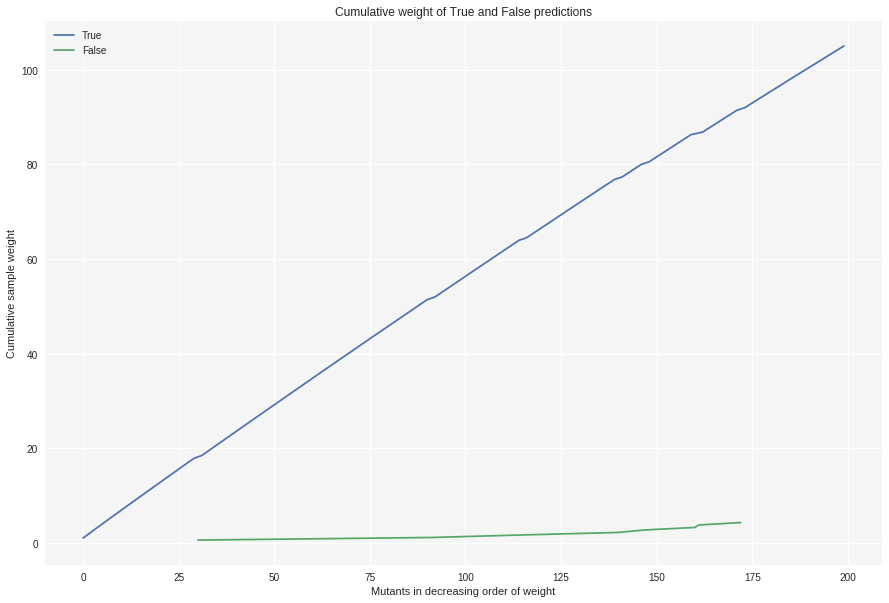

In [25]:
plt.figure(figsize=[15,10])
pT = plt.plot(x[T],sample_weights[weight_order][:r][T].cumsum())
pF = plt.plot(x[F],sample_weights[weight_order][:r][F].cumsum())
print 'False predictions start at #%d sample weight' % x[F][0]

plt.legend((pT[0], pF[0]), ('True','False'),loc=2)

plt.title("Cumulative weight of True and False predictions")
plt.ylabel("Cumulative sample weight")
plt.xlabel("Mutants in decreasing order of weight");

In [26]:
single_mutants_idx = np.asarray((np.sum(X,axis = 1) == 1)).ravel()
single_mutation_idx = np.asarray(np.sum(X[single_mutants_idx,:],axis=0) == 1).ravel()
single_mutation_idx
del single_mutants_idx

S = sparse.diags(np.ones(X.shape[1]))

In [27]:
hs = clf.predict_proba(S)

In [28]:
pos_idx = (hs[:,1]>0.9) & ~single_mutation_idx
neg_idx = (hs[:,0]>0.9) & ~single_mutation_idx
pos_mutations = zip([col_names[i] for i in xrange(pos_idx.shape[0]) if pos_idx[i]],hs[pos_idx][:,1],np.sum(X[:,pos_idx],axis = 0).tolist()[0])
neg_mutations = zip([col_names[i] for i in xrange(neg_idx.shape[0]) if neg_idx[i]],hs[neg_idx][:,0],np.sum(X[:,neg_idx],axis = 0).tolist()[0])
print len(pos_mutations),len(neg_mutations)

198 17


#### Generating code for PyMOL

bg_color white
set surface_quality, 1
set transparency, 0.5

fetch 2WUR 
show cartoon, all
hide lines, all

select waters, name o
hide everything, waters

select chr, resn GYS

color white, all
show sticks, chr
color green, chr

select aa_64_68, resi 64+68
select aa_64_68_mainchain, aa_64_68 and name C+CO+CA+N
show ribbons, aa_64_68_mainchain

In [29]:
positions = []
for m in pos_mutations[:20]:
    position = int(m[0][2:-1])
    positions.append(position)

In [30]:
for position in sorted(positions):
    color = cm.cool(10.0)
    colorName = "mCol" + str(position+2)
    selName = "mSel" + str(position+2)
    print '#' + str(position+2)
    print "set_color " + colorName + " = " +str(color[0:3])
    print "select " + selName +", resi " + str(int(position + 2))
    print "show spheres, " + selName
    print "color " + colorName + " ," + selName

#75
set_color mCol75 = (1.0, 0.0, 1.0)
select mSel75, resi 75
show spheres, mSel75
color mCol75 ,mSel75
#76
set_color mCol76 = (1.0, 0.0, 1.0)
select mSel76, resi 76
show spheres, mSel76
color mCol76 ,mSel76
#105
set_color mCol105 = (1.0, 0.0, 1.0)
select mSel105, resi 105
show spheres, mSel105
color mCol105 ,mSel105
#132
set_color mCol132 = (1.0, 0.0, 1.0)
select mSel132, resi 132
show spheres, mSel132
color mCol132 ,mSel132
#149
set_color mCol149 = (1.0, 0.0, 1.0)
select mSel149, resi 149
show spheres, mSel149
color mCol149 ,mSel149
#154
set_color mCol154 = (1.0, 0.0, 1.0)
select mSel154, resi 154
show spheres, mSel154
color mCol154 ,mSel154
#154
set_color mCol154 = (1.0, 0.0, 1.0)
select mSel154, resi 154
show spheres, mSel154
color mCol154 ,mSel154
#154
set_color mCol154 = (1.0, 0.0, 1.0)
select mSel154, resi 154
show spheres, mSel154
color mCol154 ,mSel154
#155
set_color mCol155 = (1.0, 0.0, 1.0)
select mSel155, resi 155
show spheres, mSel155
color mCol155 ,mSel155
#159
set_color 

### Making a gif

show sticks, qplex
show spheres, qplex
rotate y,90
set sphere_scale, 0.2
set stick_radius,0.15
bg_color white
set antialias,1
set depth_cue, 0
mset 1 x360
util.mroll(1,360,2)
set ray_trace_frames=1
set cache_frames=0
mclear
mpng mov

# Simultaneous mutations introduction

In [80]:
pos_mutations.sort(key=lambda x:x[2],reverse = True)
neg_mutations.sort(key=lambda x:x[2],reverse = True)

x = np.arange((len(col_names)))
top_pos_mut = x[np.in1d(col_names, [mut[0] for mut in pos_mutations[:20]])]

In [81]:
rows = 1000000
test_X = np.zeros((rows, X.shape[1]))

In [82]:
i = 0

for mutant in combinations(top_pos_mut, 5):
    for pos in mutant:
        test_X[i, pos] = 1
    i+=1
    
test_X = test_X[:i]

In [83]:
hs = clf.predict_proba(test_X)

pos_idx = (hs[:,1]>0.9)
neg_idx = (hs[:,0]>0.9)
df = pd.DataFrame(test_X[pos_idx], columns=col_names)

In [84]:
mut_combinations = [list(df.iloc[i].index[df.iloc[i]>0]) for i in range(len(df))]
selected_mutations = set([item for sublist in mut_combinations for item in sublist])

In [85]:
selected_mutations

{'SA152G',
 'SD153Y',
 'SD171E',
 'SD19E',
 'SD19Y',
 'SD232A',
 'SD232E',
 'SE233*',
 'SI227S',
 'SK124T',
 'SK138T',
 'SK154N',
 'SK154T',
 'SK156T',
 'SL13M',
 'SN103T',
 'SN210H',
 'SQ182H',
 'SQ202K',
 'ST184I'}

#### Generating code for PyMOL

In [87]:
positions = []
for m in selected_mutations:
    position = int(m[2:-1])
    positions.append(position)

In [88]:
for position in sorted(positions):
    color = cm.cool(10.0)
    colorName = "mCol" + str(position+2)
    selName = "mSel" + str(position+2)
    print '#' + str(position+2)
    print "set_color " + colorName + " = " +str(color[0:3])
    print "select " + selName +", resi " + str(int(position + 2))
    print "show spheres, " + selName
    print "color " + colorName + " ," + selName

#15
set_color mCol15 = (1.0, 0.0, 1.0)
select mSel15, resi 15
show spheres, mSel15
color mCol15 ,mSel15
#21
set_color mCol21 = (1.0, 0.0, 1.0)
select mSel21, resi 21
show spheres, mSel21
color mCol21 ,mSel21
#21
set_color mCol21 = (1.0, 0.0, 1.0)
select mSel21, resi 21
show spheres, mSel21
color mCol21 ,mSel21
#105
set_color mCol105 = (1.0, 0.0, 1.0)
select mSel105, resi 105
show spheres, mSel105
color mCol105 ,mSel105
#126
set_color mCol126 = (1.0, 0.0, 1.0)
select mSel126, resi 126
show spheres, mSel126
color mCol126 ,mSel126
#140
set_color mCol140 = (1.0, 0.0, 1.0)
select mSel140, resi 140
show spheres, mSel140
color mCol140 ,mSel140
#154
set_color mCol154 = (1.0, 0.0, 1.0)
select mSel154, resi 154
show spheres, mSel154
color mCol154 ,mSel154
#155
set_color mCol155 = (1.0, 0.0, 1.0)
select mSel155, resi 155
show spheres, mSel155
color mCol155 ,mSel155
#156
set_color mCol156 = (1.0, 0.0, 1.0)
select mSel156, resi 156
show spheres, mSel156
color mCol156 ,mSel156
#156
set_color mCol156